## Ravita Kartawinata
[Ravita's Git](https://github.com/Pii-USD/509-tm-topic-modeling)

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [29]:
# These libraries may be useful to you
# You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0

# !pip install pyLDAvis==3.4.1 --user  
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [30]:
# add any additional libaries you need here
import warnings
warnings.filterwarnings("ignore")

In [31]:
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [32]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [33]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))     
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [34]:
df.head()

,category,id,text
0,editorial,cb01,Assembly session brought much good The General...
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra..."
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...
4,editorial,cb05,Help when needed If the Dominican Republic ach...


In [35]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='category'>

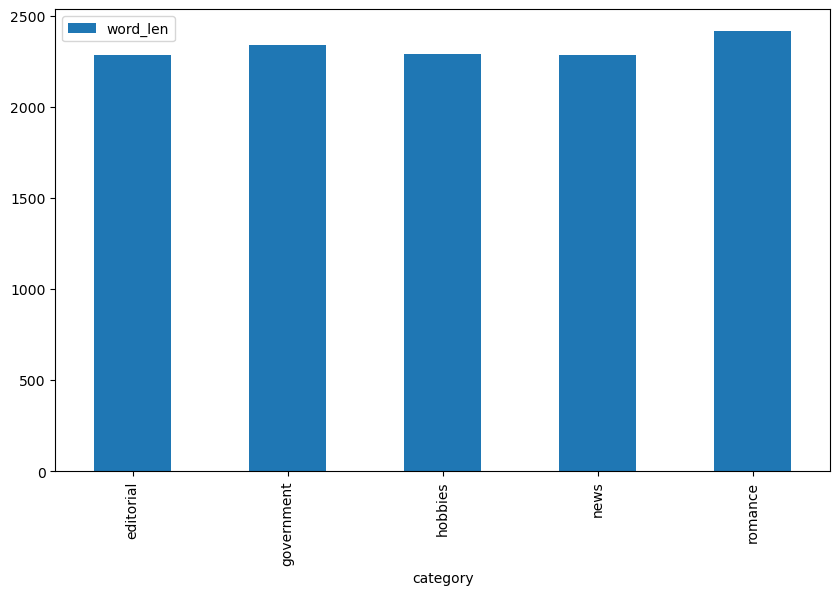

In [36]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [37]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [38]:
pd.DataFrame(count_text_vectors.toarray(), columns=count_text_vectorizer.get_feature_names_out())

,00,000,10,100,11,12,120,13,14,15,...,yes,yesterday,yield,york,young,younger,youngsters,youth,zone,zoning
0,0,3,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,3,0,0,0,1,0,1,0,0,...,0,0,0,3,0,0,0,0,2,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,0,1,0,0,0,2,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
162,0,2,0,0,0,0,0,0,1,2,...,0,0,0,3,0,0,0,0,0,0
163,0,0,4,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,0,8,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [39]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [40]:
pd.DataFrame(tfidf_text_vectors.toarray(), columns=tfidf_text_vectorizer.get_feature_names_out())

,00,000,10,100,11,12,120,13,14,15,...,yes,yesterday,yield,york,young,younger,youngsters,youth,zone,zoning
0,0.000000,0.046852,0.000000,0.000000,0.000000,0.000000,0.000000,0.023450,0.000000,0.019456,...,0.0,0.0,0.000000,0.016895,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.040107,0.000000,0.000000,0.000000,0.015896,0.000000,0.020074,0.000000,0.000000,...,0.0,0.0,0.000000,0.043389,0.000000,0.0,0.0,0.0,0.062348,0.0
2,0.000000,0.000000,0.000000,0.041794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.034956,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.016735,0.000000,0.000000,0.000000,0.039797,0.000000,0.000000,0.000000,0.020849,...,0.0,0.0,0.036429,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.014687,0.000000,0.018843,0.019635,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011308,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
162,0.000000,0.027690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018709,0.034496,...,0.0,0.0,0.000000,0.044933,0.000000,0.0,0.0,0.0,0.000000,0.0
163,0.000000,0.000000,0.037145,0.012368,0.000000,0.000000,0.022478,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
164,0.000000,0.083169,0.010015,0.013338,0.000000,0.012361,0.024242,0.000000,0.000000,0.012951,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

_A: Both of them hold the vectorized representations of the text data in numerical fomat in df. While both of them have the same shape that indicate each of vectorization contain 166 documents (or rows) and 4941 unique terms (or features). The key difference between Count and TF-IDF is in their approach to term weighting: Count Vectorization provides raw counts, while TF-IDF adjusts these counts to reflect the significance of terms relative to the entire dataset._ 

_The count_text_vectors is generated using the Count Vectorizer logic, which counts the number of times each word appears in a document. Each entry in this matrix represents the frequency of a term (word) in a specific document.
In contrast, tfidf_text_vectors is created using the TF-IDF Vectorizer logic, which is not only consider how many times a term appears in a document but also how common the term is across all documents. The lower TF-IDF score, the more frequent the word appears in many documents._

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [41]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [42]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [43]:
# Your code here
# get the highest topic for each document
df['dominant_nmf_topic'] = np.argmax(W_text_matrix, axis=1)
pd.crosstab(df['dominant_nmf_topic'], df['category'])

category,editorial,government,hobbies,news,romance
dominant_nmf_topic,,,,,
0,20,4,0,8,0
1,4,0,8,0,29
2,2,26,26,11,0
3,0,0,1,17,0
4,1,0,1,8,0


Q: How does your five-topic NMF model compare to the original Brown categories? 

_A: The five-topic NMF model shows distinct associations with the original Brown categories based on document distribution. The NMF model successfully highlights the nuanced relationships between various topics and the original categories in the Brown Corpus/ articles._

_Topic 0 is primarily focused on editorial content, with 20 articles, news (8) and government (4) articles. Topic 1 heavily emphasizes romance (29 articles), hobbies (8) and editorial articles (4). In contrast, Topic 2 has a balanced representation in a couple categories government (26) and hobbies (26) articles, indicating an overlapping. Topics 3 and 4 show more focused and minimal representation; in Topic 3 mainly contains news articles (17) and Topic 4 has very few articles across categories which means it has varying levels of content within the NMF model._

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [44]:
# Your code here
lsa_model = TruncatedSVD(n_components=5, random_state=314)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_text_vectors)
lsa_components = lsa_model.components_

In [45]:
df['dominant_lsa_topic']  = lsa_topic_matrix.argmax(axis=1)

In [46]:
pd.crosstab(df['dominant_lsa_topic'], df['category'])

category,editorial,government,hobbies,news,romance
dominant_lsa_topic,,,,,
0,27,30,36,34,21
1,0,0,0,0,8
3,0,0,0,3,0
4,0,0,0,7,0


Q: How does your five-topic LSA model compare to the original Brown categories? 

_A: The five-topic LSA model shows relationships between the topics and the original categories in the Brown Corpus. LSA Topic 0 is the most dense and prevalent. It has substantial counts across several categories; hobbies (36), news (34). This means that Topic 0 captures a wide range of documents and broad thematic coverage, highlighting its significance in the model. However, the lack of representation in Topics 1, 3, and 4 is notable. Topic 1 only includes 8 articles in romance, and the other topics have minimal contributions, highlighting limitations in capturing the full diversity of the original corpus._

_NMF model shows a clearer separation of topics, with certain topics directly corresponding to specific categories in the Brown Corpus i.e Topic 1 strongly representing romance and Topic 2 focusing on government and hobbies. Meanwhile LSA model shows broader and less distinct topic distributions, with Topic 0 encompassing high counts across multiple categories, particularly in hobbies (36 articles) and news (34 articles), indicating a generalization of themes rather than specialization. Overall, NMF provides more clarity and differentiation among categories and LSA offers a wider view of topic relationships across the corpus._

In [47]:
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

_A: LSA model shows five distinct topics, ranging from conversational narratives to historical and political, social events, and sports. Topic 00 sounds more focuses on politics, while Topic 01 captures informal dialogue and everyday storytelling. Topics 02 and 03 highlight historical figures and social activities and Topic 04 clearly focuses on sports, particularly baseball. Overall, the LSA model could uncovers a variety of themes in the text, reflecting the diverse content of the dataset._

_Comparing with NMF model which displays more distinct topics, while LSA's topics are broader and more general can be seen from the score that each words get. Therefore as we can see from crosstab and display topic result, NMF provides clearer thematic separation, LSA blends categories, with some topics carrying multiple themes, making it less focused._

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [48]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_text_model.fit_transform(count_text_vectors)
lda_components = lda_text_model.components_

In [49]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


Q: What inference do you draw from the displayed topics for your LDA model? 

_A: LDA model indicates distinct themes within the text data. Topic 00 seems to revolve around a game or home-related context, while Topic 01 focuses on state development and programs. Topics 02 and 04 highlight political figures and general statements, while Topic 03 pertains to business or property matters._

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

_A: Comparing LDA model and original Brown Categories shows that they do not neatly align to each other, since LDA reflects a diverse range of subjects. Topic 02, which includes words like “said,” “mr,” and “president,” suggests a political or government-related content, potentially overlapping with the “government” category from the Brown corpus. In contrast, topics like Topic 00, with words such as “home,” “game,” and “way,” appear to touch on everyday life and could relate to categories like “hobbies” or “fiction,” indicating a broader interpretation of content compared to the more defined classifications in the Brown corpus._

In [50]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [51]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

_A: The left plot shows the relationship between the topics in the model. Each circle represents a topic, and its position is shown the similarity to other topics.The closer two topics, the more similar their word distributions are.
In this case, we can see that topic 2, 3 and 4 are relatively close to each other, suggesting that they share some similar characteristics. Topic 1 and 5 seem to be somewhat distant from the other topics, indicating a distinct theme_

_The bar graph shows the most important terms for each topic, along with their estimated term frequency within the topic and their overall term frequency. For example, Topic 3 the most important terms include "said," "mr," "president," "state" which indicates that topic 3 may be related to political or historical events. The length of the bar indicates the estimated term frequency within the topic, while the color represents the overall term frequency._

**References:**

- Dib, F. (n.d.). Build, test, and debug regex. regex101. https://regex101.com/
  
- OpenAI. (2024). ChatGPT (October 24 version) [Large language model]. https://chat.openai.com/chat

- Chandler, J. (n.d.). 37chandler/ads-tm-topic-modeling. GitHub. https://github.com/37chandler/ads-tm-topic-modeling

- Albrecht, R. (n.d.). Blueprints for text analysis using python. GitHub. https://github.com/blueprints-for-text-analytics-python/blueprints-text 

\newpage
## FOR RAVITA REFERENCE ONLY

In [52]:
##### CAN BE DELETED#### ChatGpt
topic_category_tally = defaultdict(lambda: defaultdict(int))

# Loop through the DataFrame to populate the tally
for index, row in df.iterrows():
    topic = row['dominant_nmf_topic']  # Get the NMF topic for the current document
    category = row['category']  # Get the original Brown category for the current document
    topic_category_tally[topic][category] += 1  # Increment the tally

tally_rows = []

for topic, categories in topic_category_tally.items():
    for category, count in categories.items():
        tally_rows.append((topic, category, count))

pd.DataFrame(tally_rows, columns=['NMF Topic', 'Brown Category', 'Count'])

,NMF Topic,Brown Category,Count
0,2,editorial,2
1,2,government,26
2,2,news,11
3,2,hobbies,26
4,0,editorial,20
5,0,government,4
6,0,news,8
7,1,editorial,4
8,1,romance,29
9,1,hobbies,8


In [53]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

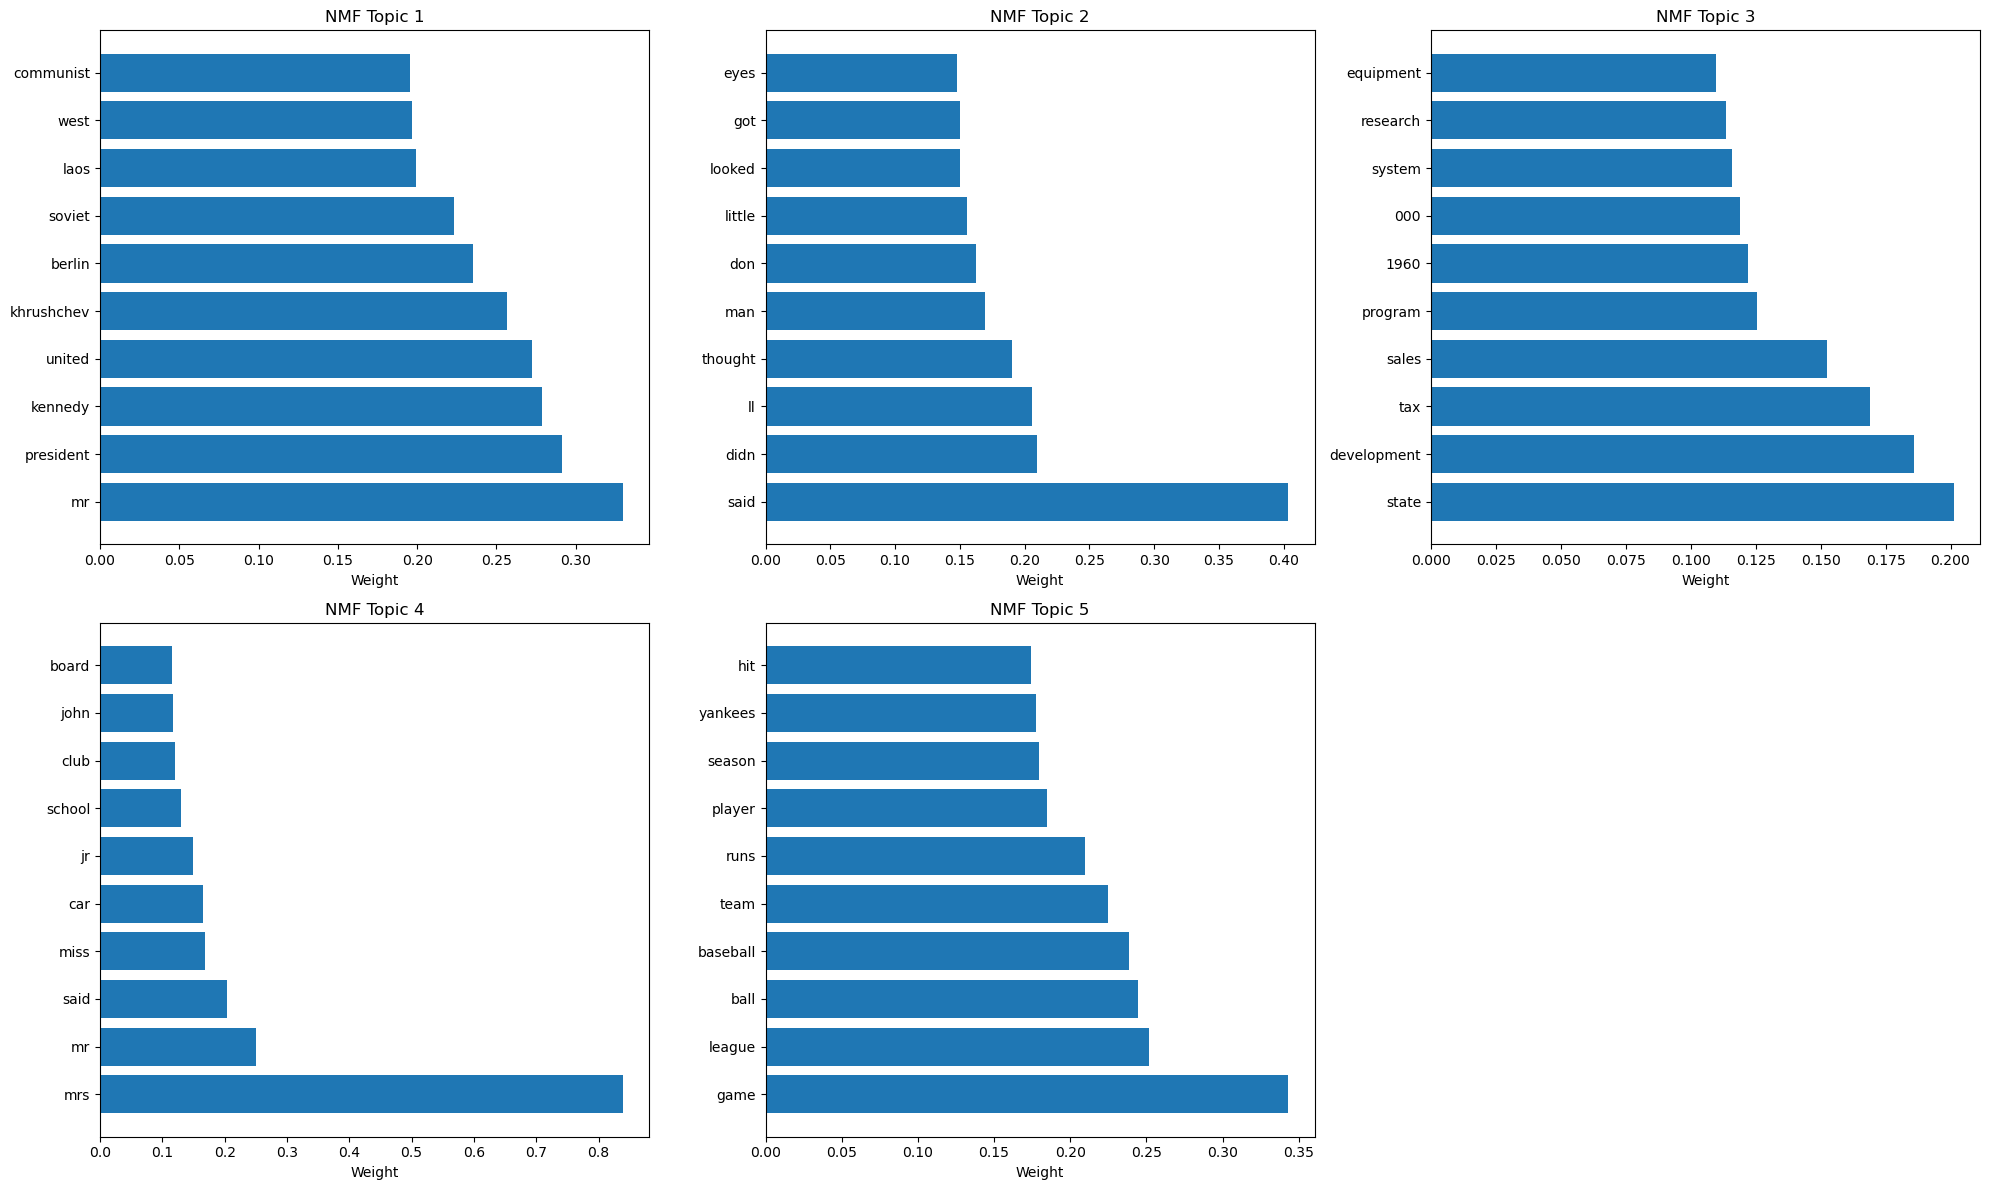

In [54]:
feature_names = tfidf_text_vectorizer.get_feature_names_out()

n_topics = 5
n_top_words = 10

fig, axes = plt.subplots(2,3, figsize=(20, 12))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for topic_idx, topic in enumerate(H_text_matrix):
    if topic_idx < n_topics: 
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        axes[topic_idx].barh(top_features, weights, align='center')
        axes[topic_idx].set_title(f'NMF Topic {topic_idx + 1}')
        axes[topic_idx].set_xlabel('Weight')

for i in range(len(H_text_matrix), 6):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

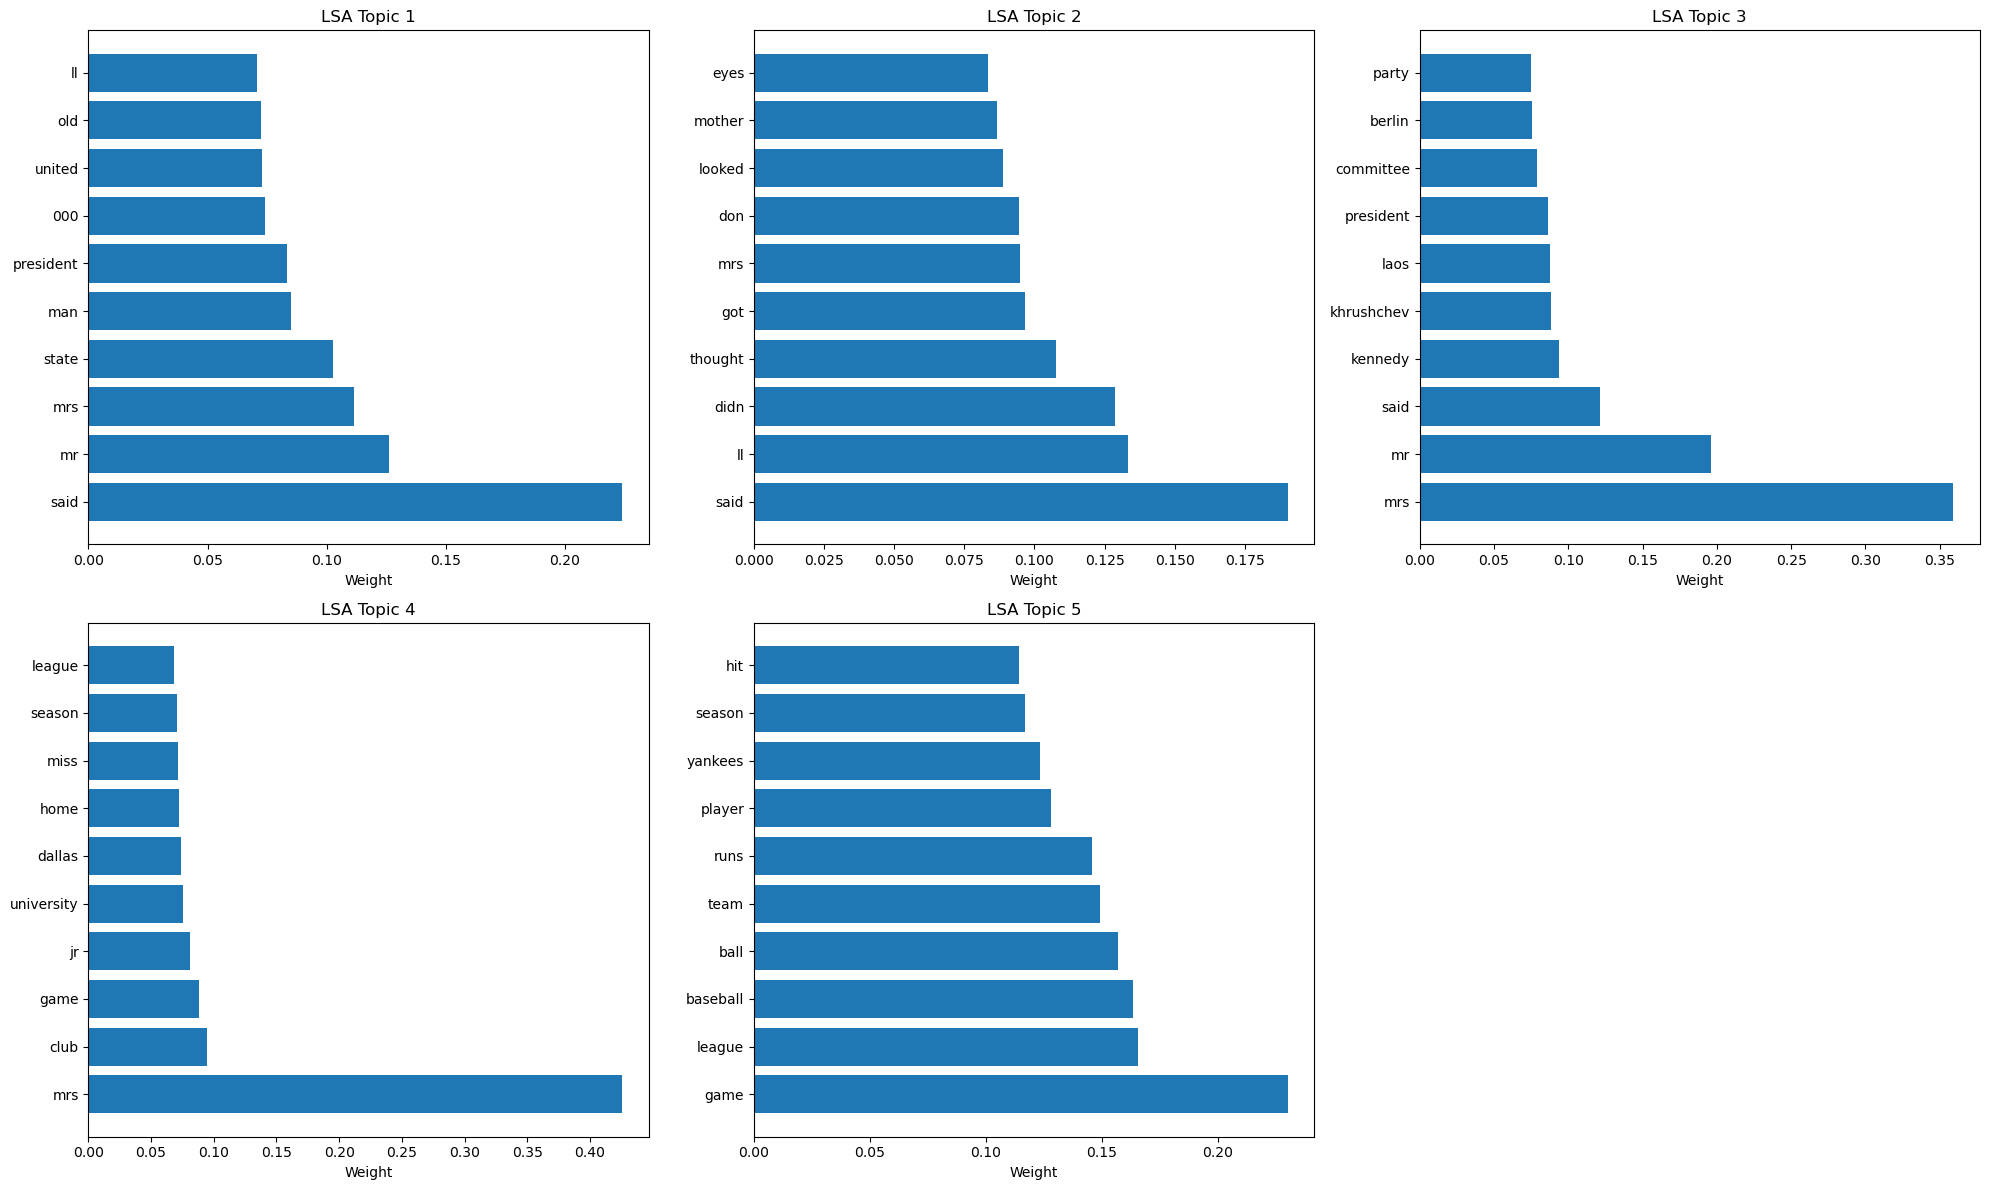

In [55]:
n_topics = 5
n_top_words = 10

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for topic_idx in range(n_topics):
    topic = lsa_components[topic_idx]
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    axes[topic_idx].barh(top_features, weights, align='center')
    axes[topic_idx].set_title(f'LSA Topic {topic_idx + 1}')
    axes[topic_idx].set_xlabel('Weight')

for i in range(n_topics, 6):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

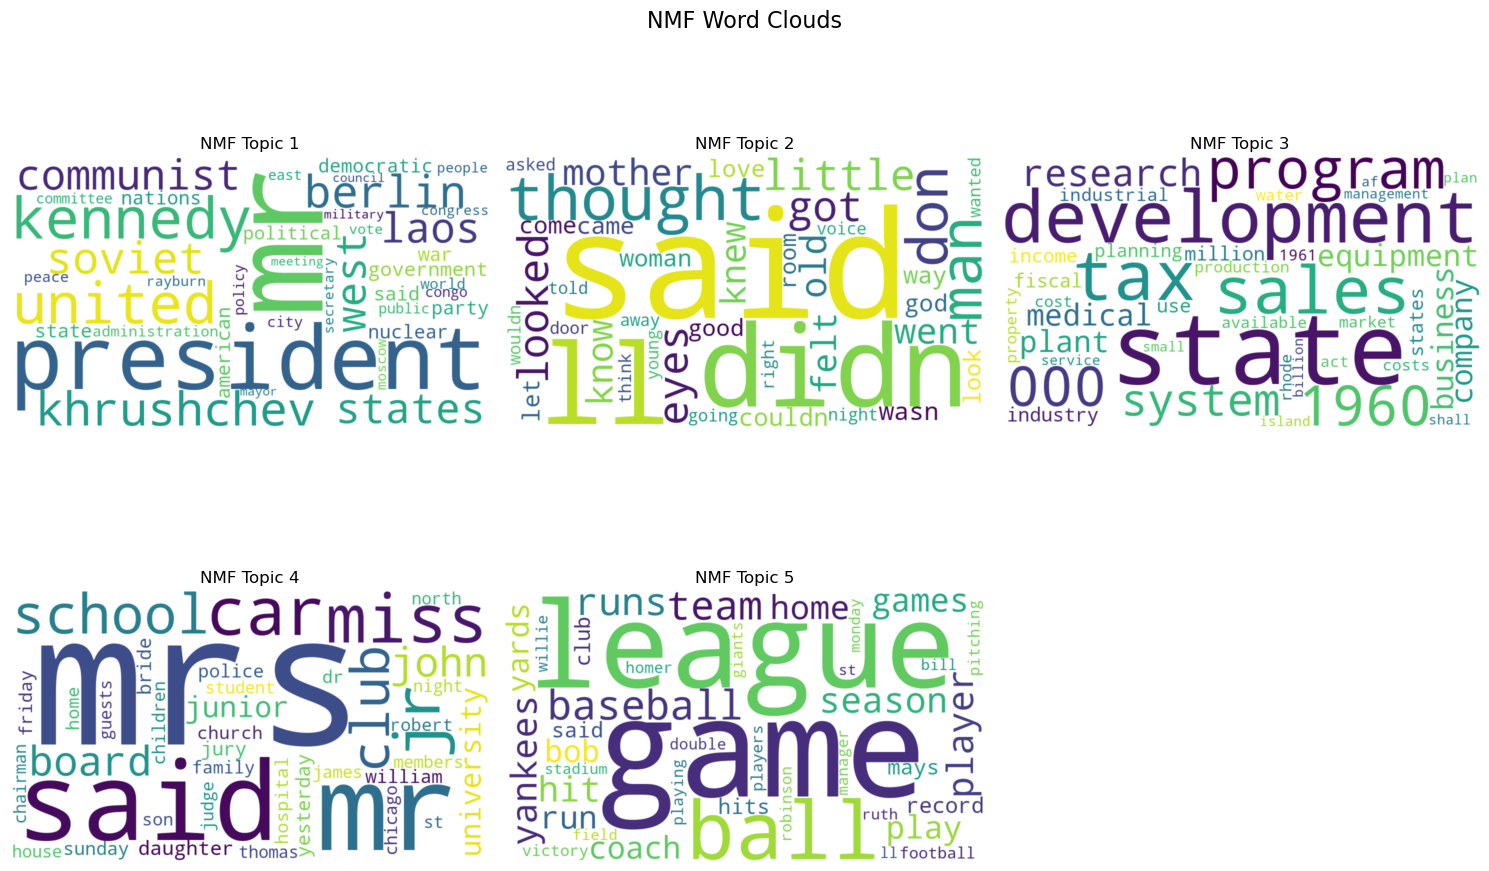

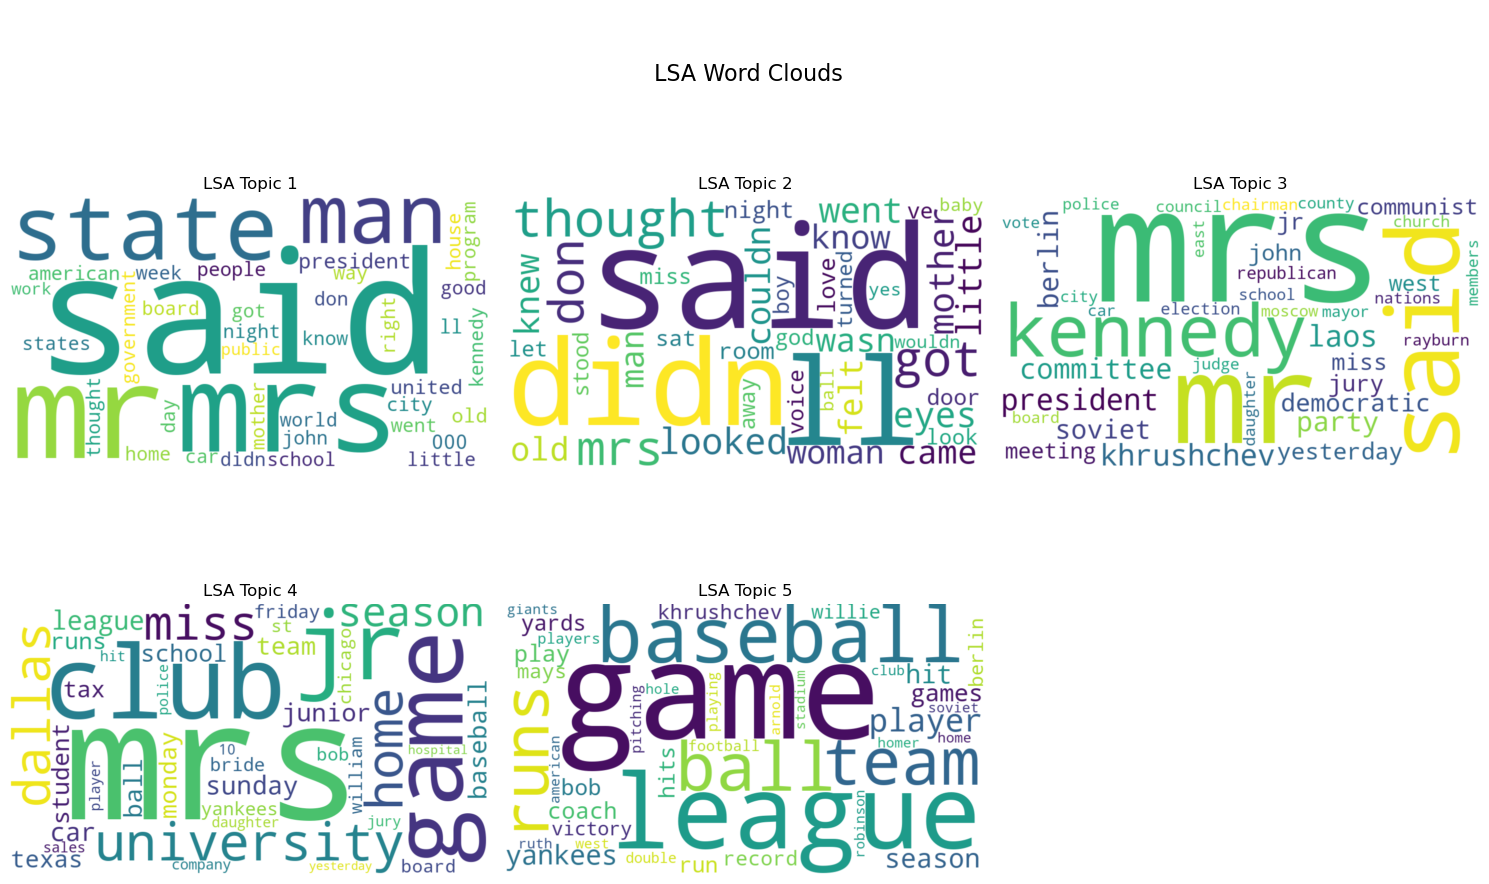

In [56]:
#BTaP
def wordcloud_topics(model, features, no_top_words=40):
    wordclouds = []
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1]  
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        wordclouds.append(wc)
    
    return wordclouds

nmf_wordclouds = wordcloud_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())
lsa_wordclouds = wordcloud_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())

plt.figure(figsize=(15, 10))
for i, wc in enumerate(nmf_wordclouds):
    plt.subplot(2, 3, i + 1) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'NMF Topic {i + 1}')

plt.suptitle('NMF Word Clouds', fontsize=16)
plt.tight_layout()
plt.show()

# grid for LSA Word Clouds (2x3)
plt.figure(figsize=(15, 10))
for i, wc in enumerate(lsa_wordclouds):
    plt.subplot(2, 3, i + 1)  
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'LSA Topic {i + 1}')

plt.suptitle('\n\n LSA Word Clouds', fontsize=16)
plt.tight_layout()
plt.show()